In [2]:
'''
Data scrapping module
'''

from selenium.webdriver import Chrome, ChromeOptions
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import json
import requests
import os.path

caps = DesiredCapabilities.CHROME
caps['goog:loggingPrefs'] = {'performance' : 'ALL'}

options = ChromeOptions()
options.add_argument('headless')

driver = Chrome(desired_capabilities=caps, options=options)

pages = 1

while pages <= 5406:

    driver.get(f'https://www.daf-yomi.com/Dafyomi_Page.aspx?id={pages}&vt=1&fs=0')
    browser_log = driver.get_log('performance')
    events = [json.loads(entry['message'])['message'] for entry in browser_log]
    
    for e in events:

        if 'url' in e['params']:
            url = e['params']['url'].split('#')[0]
            r1 = requests.get(url, stream=True)
            
            if(r1.status_code == 200):
                with open(os.path.join(os.getcwd(), 'data_set', 'high_res_pdf', f'{pages}.pdf'),'ab') as file:
                    for chunk in r1.iter_content(chunk_size=1024):
                        file.write(chunk)
    pages += 1


KeyboardInterrupt



In [9]:
import random
import numpy as np
import cv2
import pdfplumber
import os
from augraphy import *


high_res_pdf_path = os.path.join('data_set', 'high_res_pdf')
inputs_path = os.path.join('data_set', 'inputs')
outputs_path = os.path.join('data_set', 'outputs')

ink_phase = [

    InkBleed(
        intensity_range=(0.1, 0.2),
        color_range=(0, 16),
        kernel_size=random.choice([(7, 7), (5, 5), (3, 3)]),
        severity=(0.4, 0.6),
),
    OneOf(
        [
            Letterpress(
                n_samples=(100, 400),
                n_clusters=(200, 400),
                std_range=(500, 3000),
                value_range=(150, 224),
                value_threshold_range=(96, 128),
                blur=1,
            ),
            BleedThrough(
                intensity_range=(0.1, 0.3),
                color_range=(32, 224),
                ksize=(17, 17),
                sigmaX=1,
                alpha=random.uniform(0.1, 0.2),
                offsets=(10, 20),
            ),
        ],
    ),
]

paper_phase = []

post_phase = [
    OneOf(

        [DirtyRollers(
            line_width_range=(2, 32),
            scanline_type=0,
            p=0.33,
        ),
        DirtyDrum(
            line_width_range=(1, 6),
            line_concentration=random.uniform(0.05, 0.15),
            direction=random.randint(0, 2),
            noise_intensity=random.uniform(0.6, 0.95),
            noise_value=(64, 224),
            ksize=random.choice([(3, 3), (5, 5), (7, 7)]),
            sigmaX=0,
            p=0.33,
        ),
        Jpeg(
            quality_range=(25, 95),
            p=0.33,
        ),
        Folding(
            fold_x=None,
            fold_deviation=(0, 0),
            fold_count=random.randint(1, 6),
            fold_noise=random.uniform(0, 0.2),
            gradient_width=(0.1, 0.2),
            gradient_height=(0.01, 0.02),
            p=0.33,
        ),
        PencilScribbles(
            size_range=(100, 800),
            count_range=(1, 6),
            stroke_count_range=(1, 2),
            thickness_range=(2, 6),
            brightness_change=random.randint(64, 224),
            p=0.33,
        ),
        BadPhotoCopy(
            mask=None,
            noise_type=-1,
            noise_side="random",
            noise_iteration=(1, 2),
            noise_size=(1, 3),
            noise_value=(128, 196),
            noise_sparsity=(0.3, 0.6),
            noise_concentration=(0.1, 0.6),
            blur_noise=random.choice([True, False]),
            blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
            wave_pattern=random.choice([True, False]),
            edge_effect=random.choice([True, False]),
            p=0.33,
        ),
        Faxify(
            scale_range=(0.3, 0.6),
            monochrome=random.choice([0, 1]),
            monochrome_method="random",
            monochrome_arguments={},
            halftone=random.choice([0, 1]),
            invert=1,
            half_kernel_size=random.choice([(1, 1), (2, 2)]),
            angle=(0, 360),
            sigma=(1, 3),
            p=0.33,
        ),
        BookBinding()
        ]
    )
]

pipeline = AugraphyPipeline(ink_phase, paper_phase, post_phase)

img = cv2.imread("image.png")



ls = os.listdir(high_res_pdf_path)
count = 1

for file in ls:
    pdf = pdfplumber.open(os.path.join(high_res_pdf_path, file))
    page = pdf.pages[0]
    page = page.to_image(resolution=150)
    page = page.original
    page = np.asarray(page)
    page = cv2.cvtColor(page, cv2.COLOR_RGB2GRAY)
    augmented = pipeline.augment(page)
    augmented = augmented["output"]

    #We will make grid 5*7 with size of 256*256 for each piece
    for i in range(5):
        for j in range(7):
            #piece = page[j*256:(j+1)*256, i*256:(i+1)*256]
            #cv2.imwrite(os.path.join(outputs_path, f'{count}.png'), piece)
            aug_piece = augmented[j*256:(j+1)*256, i*256:(i+1)*256]
            cv2.imwrite(os.path.join(inputs_path, f'{count}.png'), aug_piece)
            count += 1


In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow import TensorSpec
from tensorflow.data import Dataset

inputs_path = os.path.join('data_set', 'inputs')
outputs_path = os.path.join('data_set', 'outputs')

files = os.listdir(inputs_path)
test_data_indexes = [i for i in range(0, len(files), 10)]

def train_generator():
    for i in range(len(files)):
        if i not in test_data_indexes:
            inp = cv2.imread(os.path.join(inputs_path, files[i]))
            tar = cv2.imread(os.path.join(outputs_path, files[i])).astype('float32')
            inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
            tar = cv2.cvtColor(tar, cv2.COLOR_BGR2GRAY)
            yield inp, tar

def test_generator():
    for i in range(len(files)):
        if i in test_data_indexes:
            inp = cv2.imread(os.path.join(inputs_path, files[i]))
            tar = cv2.imread(os.path.join(outputs_path, files[i])).astype('float32')
            inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
            tar = cv2.cvtColor(tar, cv2.COLOR_BGR2GRAY)
            yield inp, tar 

train_data = Dataset.from_generator(train_generator, output_signature=(
    TensorSpec(shape=(256, 256), dtype=tf.uint8),
    TensorSpec(shape=(256, 256), dtype=tf.float32)
)).batch(8)
test_data = Dataset.from_generator(train_generator, output_signature=(
    TensorSpec(shape=(256, 256), dtype=tf.uint8),
    TensorSpec(shape=(256, 256), dtype=tf.float32)
)).batch(8)


In [2]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, LeakyReLU, ReLU, BatchNormalization, Concatenate, Reshape, Activation
from tensorflow.keras.initializers import RandomNormal


def double_conv(out_c, init):
    return Sequential([
        Conv2D(out_c, 3, padding='same', use_bias=False, kernel_initializer=init),
        BatchNormalization(),
        ReLU(),
        Conv2D(out_c, 3, padding='same', use_bias=False, kernel_initializer=init),
        BatchNormalization(),
        LeakyReLU()
    ])

def generator():
    init = RandomNormal(stddev=0.02)
    features = [64, 128, 256, 512]
    reshape = Reshape((256, 256, 1))
    downs = []
    ups = []
    pool = MaxPool2D(pool_size=(2, 2), padding='same')

    for feature in features:
        downs.append(double_conv(feature, init))

    for feature in reversed(features):
        ups.append(Conv2DTranspose(feature, padding='same', kernel_size=2, strides=2, kernel_initializer=init))
        ups.append(double_conv(feature, init))

    bottle_neck = double_conv(features[-1]*2, init)
    final_conv = Conv2D(1, 1, 1, padding='same', kernel_initializer=init)
    final_activation = Activation('sigmoid')

    x = Input(shape=(256, 256))
    x = reshape(x)
    skips = []

    for down in downs:
        y = down(x)
        skips.append(x)
        y = pool(x)

    y = bottle_neck(x)
    skips = skips[::-1]

    for i in range(0, len(ups), 2):
        y = ups[i](x)
        skip = skips[i//2]
        concat = Concatenate()([x, skip])
        y = ups[i+1](concat)

    y = final_conv(y)
    y = final_activation(y)
    return Model(inputs=x, outputs=y)

def discriminator():
    optimizer = tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.5)
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    init = RandomNormal(stddev=0.02)
    input_real = Input(shape=(256, 256))
    x_real = Reshape((256, 256, 1))(input_real)
    input_fake = Input(shape=(256, 256))
    x_fake = Reshape((256, 256, 1))(input_fake)
    concat = Concatenate()([x_real, x_fake])
    disc = Conv2D(64, 4, padding='same', kernel_initializer=init)(concat)
    disc = LeakyReLU(0.01)(disc)
    disc = MaxPool2D(2, padding='same')(disc)
    disc = Conv2D(128, 4, padding='same', kernel_initializer=init)(disc)
    disc = LeakyReLU(0.01)(disc)
    disc = MaxPool2D(2, padding='same')(disc)
    disc = Conv2D(256, 4, padding='same', kernel_initializer=init)(disc)
    disc = LeakyReLU(0.01)(disc)
    disc = BatchNormalization()(disc)
    disc = MaxPool2D(2, padding='same')(disc)
    disc = Conv2D(256, 4, padding='same', kernel_initializer=init)(disc)
    disc = LeakyReLU(0.01)(disc)
    disc = BatchNormalization()(disc)
    disc = MaxPool2D(2, padding='same')(disc)
    disc = Conv2D(256, 4, padding='same', kernel_initializer=init)(disc)
    disc = LeakyReLU(0.01)(disc)
    disc = BatchNormalization()(disc)
    disc = Conv2D(1, 4, padding='same', kernel_initializer=init)(disc)
    disc = Activation('sigmoid')(disc)
    model = Model(inputs=[input_real, input_fake], outputs=disc)
    model.compile(loss=loss_object, optimizer=optimizer, loss_weights=[0.5])
    return model

def gan_model(gen, disc):
    optimizer = tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.5)
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    for l in disc.layers:
        if not isinstance(l, BatchNormalization):
            l.trainable = False
    inp = Input(shape=(256, 256))
    gen_out = gen(inp)
    disc_out = disc([inp, gen_out])
    model = Model(inp, [gen_out, disc_out])
    model.compile(optimizer=optimizer, loss=[loss_object, 'mae'], loss_weights=[1, 100])
    return model


In [3]:
import time
from matplotlib import pyplot as plt
from IPython import display
gen = generator()
disc = discriminator()
gan = gan_model(gen, disc)

def train(g, d, gan, steps):
    plt.figure(figsize=(15, 15))
    total_time = time.time()
    for step, (input_image, target) in train_data.enumerate():
        if step == steps:
            break
        step_time = time.time()
        fake_image = g.predict(input_image)
        y_real = tf.ones((8, 16, 16, 1))
        y_fake = tf.zeros((8, 16, 16, 1))
        d_loss1 = d.train_on_batch([input_image, target], y_real)
        d_loss2 = d.train_on_batch([input_image, fake_image], y_fake)
        g_loss, _, _ = gan.train_on_batch(input_image, [target, y_real])
        display.clear_output(wait=True)
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        display_list = [input_image[0], target[0], fake_image[0]]
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title = title[i]
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        print(f'Step: {step+1}, Discriminator losses: {d_loss1:.2f}, {d_loss2:.2f}, Generator loss: {g_loss:.2f}, Total time: {time.time()-total_time:.2f} sec, Step time {time.time()-step_time:.2f} sec')
    print('\n')

c:\Users\Aleksandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\Aleksandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


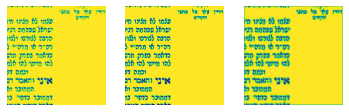

Step: 438, Discriminator losses: 0.00, 0.00, Generator loss: -39.35, Total time: 789.31 sec, Step time 1.70 sec
1/1 [==============================] - 0s 22ms/step


In [7]:
try:
    train(gen, disc, gan, 10000)
except KeyboardInterrupt:
    gen.save_weights('.\\model\\generator.h5')
    disc.save_weights('.\\model\\discriminator.h5')
else:
    pass